# Example: Visualizing vzlusat2-RITE data

In [1]:
%matplotlib ipympl

In [2]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as colors

import rite_vs2
import rite_vs2.decoder as rdc
import rite_vs2.utils as rutils
import rite_vs2.hexchunks as hexchunks

In [3]:
# chunk/packets processors
metada_proc = rdc.metadada_processor()
data_proc = rdc.datastream_processor()

# chnk import function
read_chunk = rdc.read_chunk_v2

# DK storage ports
port_META = rite_vs2.DK_PORT_META
port_DATA = rite_vs2.DK_PORT_DATA

det_id = 'C07-W0337'   # flight CdTe detector (v2)

For reading and processing chunks we are using multiple steps:

1. Find a particular chunk or range of chunks by PORT , acquisition date or chunk ID using `rite_vs2.utils.hexchunks.find_chunk`
2. Create an ordered chunk dictionary using `rite_vs2.utils.hexchunks.index_chunks_by_id`
3. Use `rite_vs2.decoder.read_chunk_v2` to effectively read chunks from the ordered dictionary.

In [4]:
# METADATA chunk
meta_chunk_id = 244

d_start='2022-07-08'
d_end='2022-07-10'

# find and load METADATA chunks
chunks, _ = hexchunks.find_chunks(port=port_META, chunk_id=meta_chunk_id, date_start=d_start, date_end=d_end)
indexed_chunks = hexchunks.index_chunks_by_id(chunks)
chunks = None # release memory
chunk_meta, dk_id, dk_time = read_chunk(meta_chunk_id, indexed_chunks)

if chunk_meta is not None:
    # print info
    print('[INFO] chunkID:', dk_id)
    print('[INFO] dk_time:', dk_time, 'UTC')
    print('')
    # print chunk
    pck_info = metada_proc.process(chunk_meta)
    rdc.print_metadata(pck_info)

[INFO] chunkID: 244
[INFO] dk_time: 2022-07-09 14:34:04 UTC

[RITE] start_nb: 9
[MEAS] exp_nb: 0
[MEAS] frame_id: 0x0900
[MEAS] time: 2022-07-09 14:30:02.020 UTC
[DATA] outputForm: 609
[DATA] firstChunkId: 1216
[DATA] lastChunkId: 2668
[DET] mode: 1
[DET] scan mode, (count) threshold, roi: 1, 500, 0
[DET] frameTime: 0.2 (sec)
[DET] bias: 200 (V)
[DET] threshold: 5.01634 (keV)
[DET] nFrames: 500
[PROC] filtering: 6
[PROC] (frame) min, max, (filtered) min, max:          3       7672          5        404
[PROC]    id  row  col  hgt  wdh  frame-evt   filt-evt  frame-sum   filt-sum
[PROC] roi0:    0    0  256  256      21481        214     977937       8932
[PROC] roi1:    0    0  128  128       3355         50     128550       2125
[PROC] roi2:    0  128  128  128       5917         45     337782       2076
[PROC] roi3:  128    0  128  128       5742         56     228192       2025
[PROC] roi4:  128  128  128  128       6467         63     283413       2706


In [5]:
# DATA chunks processing loop

data_proc.reset() # same processor can be reused for different measurements

# find and load DATA chunks
chunks, _ = hexchunks.find_chunks(port=port_DATA, date_start=d_start, date_end=d_end)
indexed_chunks = hexchunks.index_chunks_by_id(chunks)
chunks = None # release memory

for k in range(pck_info['first_chunk'], pck_info['last_chunk']+1):
    chunk_pck, _, _ = read_chunk(k, indexed_chunks)
    
    if chunk_pck is None:
        print("ERROR: Could not read chunk_id=%d" % k)
        continue
    
    data_proc.process(chunk_pck)

# print some data overview    
data_proc.print_info()

# get result
data = data_proc.data

# show typical access to data items, note: some of them may be still lists of arrays
ehist = data['ehist']
bin8 = data['bin8']
bin16 = data['bin16']
bin32 = data['bin32']
filt = data['filt']
frame = data['frame']
col_proj = data['col_proj']
row_proj = data['row_proj']

[DATA] frame:  (256, 256)
[DATA] filt:  (256, 256)
[DATA] col_proj:  [None, None, None, None, None]
[DATA] row_proj:  [None, None, None, None, None]
[DATA] bin8:  None
[DATA] bin16:  None
[DATA] bin32:  None
[DATA] ehist:  [((16,), 404), ((16,), 404), ((16,), 404), ((16,), 404), ((16,), 404)]


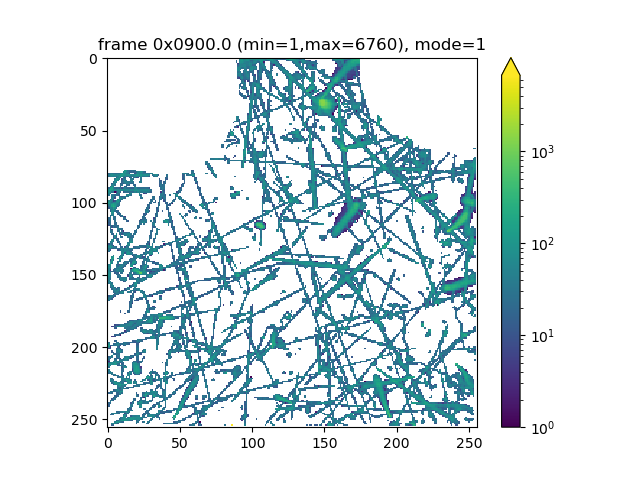

In [6]:
# plot frame

if frame is not None:
    plt.figure()
    img = frame
    plt.subplot(111), plt.title('frame 0x%04x.%d (min=%d,max=%d), mode=%d' % (pck_info['frame_id'], pck_info['exp_nb'], 
                                                                              np.min(img[img>0]),np.max(img),pck_info['meas_mode'],))
    imgplot = plt.imshow(img, interpolation='none', norm=colors.LogNorm(vmin=1, vmax=img.max()))
    cbar = plt.colorbar(extend='max')
    cbar.minorticks_on()
else:
    print("No frame data")

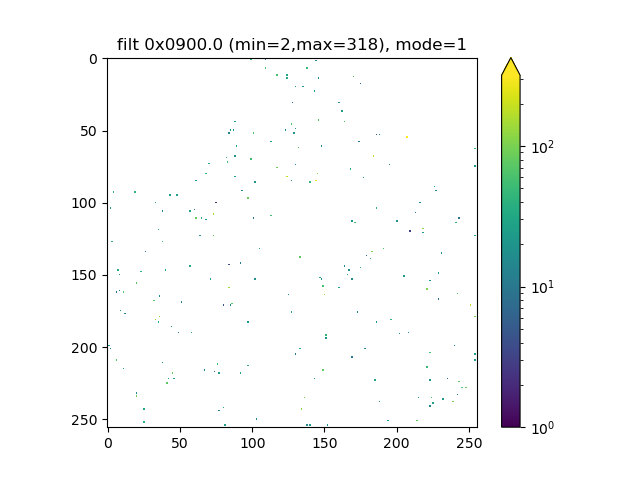

In [7]:
# plot filt

if filt is not None:
    plt.figure()
    img = filt
    plt.subplot(111), plt.title('filt 0x%04x.%d (min=%d,max=%d), mode=%d' % (pck_info['frame_id'], pck_info['exp_nb'], 
                                                                             np.min(img[img>0]),np.max(img),pck_info['meas_mode'],))
    imgplot = plt.imshow(img, interpolation='none', norm=colors.LogNorm(vmin=1, vmax=img.max()))
    cbar = plt.colorbar(extend='max')
    cbar.minorticks_on()
else:
    print("No filt data")

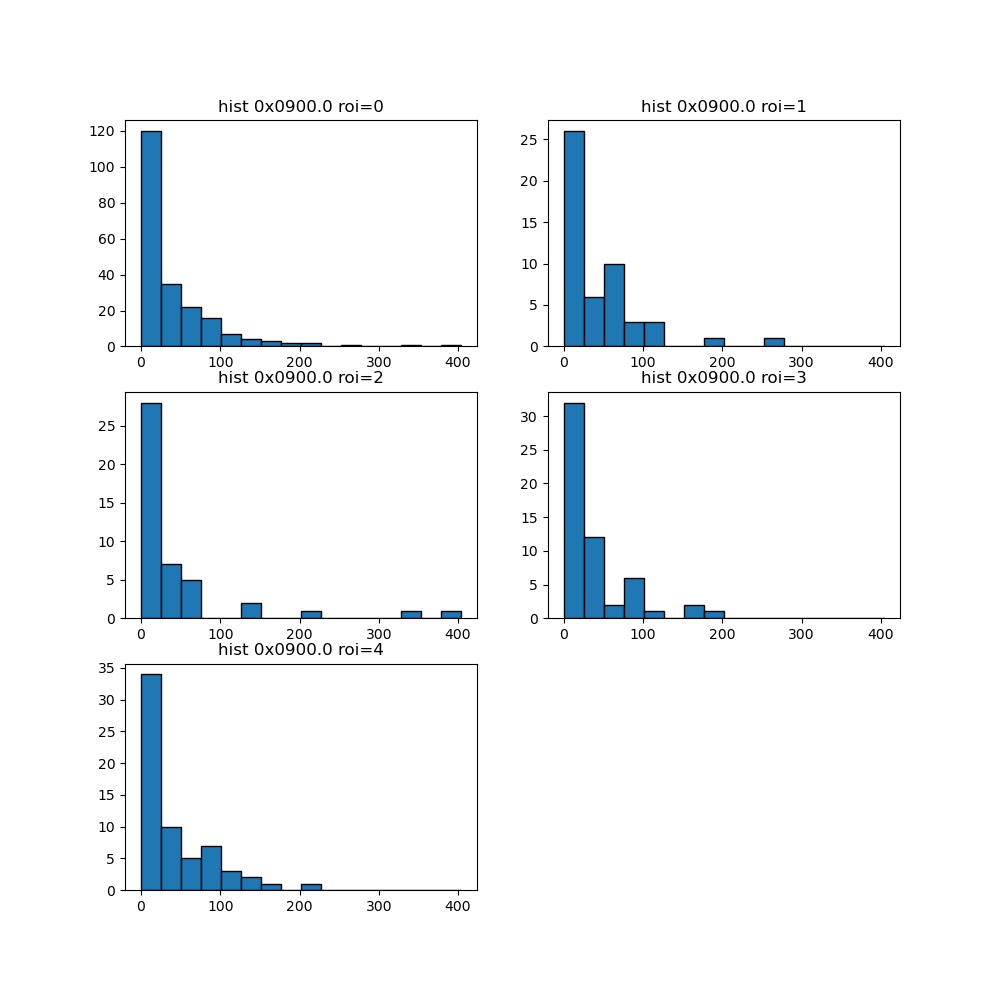

In [8]:
# plot ehist

plt.figure(figsize=(10, 10), dpi=100)

if ehist is not None:
    for iroi in range(rite_vs2.DET_NROIS):
        if ehist[iroi][0] is not None:
            plt.subplot(3,2,iroi+1), plt.title('hist 0x%04x.%d roi=%d' % (pck_info['frame_id'], pck_info['exp_nb'], iroi,))
            edges = np.linspace(0,ehist[iroi][1],rite_vs2.DET_EHIST_NBINS+1)
            plt.bar(edges[:-1], ehist[iroi][0], width=np.diff(edges), edgecolor="black", align="edge")
else:
    print("No ehist data")

In [9]:
# plot bin8

if bin8 is not None:
    plt.figure()
    img = bin8
    plt.subplot(111), plt.title('bin8 0x%04x.%d (min=%d,max=%d), mode=%d' % (pck_info['frame_id'], pck_info['exp_nb'],
                                                                             np.min(img[img>0]),np.max(img),pck_info['meas_mode'],))
    imgplot = plt.imshow(img, interpolation='none', norm=colors.LogNorm(vmin=1, vmax=img.max()))
    cbar = plt.colorbar(extend='max')
    cbar.minorticks_on()
else:
    print("No bin8 data")

No bin8 data


In [10]:
# plot bin16

if bin16 is not None:
    plt.figure()
    img = bin16
    plt.subplot(111), plt.title('bin16 0x%04x.%d (min=%d,max=%d), mode=%d' % (pck_info['frame_id'], pck_info['exp_nb'], 
                                                                              np.min(img[img>0]),np.max(img),pck_info['meas_mode'],))
    imgplot = plt.imshow(img, interpolation='none', norm=colors.LogNorm(vmin=1, vmax=img.max()))
    cbar = plt.colorbar(extend='max')
    cbar.minorticks_on()
else:
    print("No bin16 data")

No bin16 data


In [11]:
# plot bin32

if bin32 is not None:
    plt.figure()
    img = bin32
    plt.subplot(111), plt.title('bin32 0x%04x.%d (min=%d,max=%d), mode=%d' % (pck_info['frame_id'], pck_info['exp_nb'], 
                                                                              np.min(img[img>0]),np.max(img),pck_info['meas_mode'],))
    imgplot = plt.imshow(img, interpolation='none', norm=colors.LogNorm(vmin=1, vmax=img.max()))
    cbar = plt.colorbar(extend='max')
    cbar.minorticks_on()
else:
    print("No bin32 data")

No bin32 data


In [12]:
# plot col_proj

if col_proj[0] is not None:
    plt.figure(figsize=(12, 14), dpi=100)
    for iroi in range(rite_vs2.DET_NROIS):
        if col_proj[iroi] is not None:
            roi = pck_info['rois'][iroi]
            first = roi[1]
            last = roi[1]+roi[3]
            plt.subplot(3,2,iroi+1), plt.title('col_proj 0x%04x.%d roi=%d' % (pck_info['frame_id'], pck_info['exp_nb'], iroi,))
            x = np.linspace(first,last,last-first+1,endpoint=True)
            xx = np.zeros((2*(x.size-1),))
            xx[0::2] = x[:-1]
            xx[1::2] = x[1:]
            yy = np.zeros((2*(x.size-1),))
            yy[0::2] = col_proj[iroi]
            yy[1::2] = col_proj[iroi]
            plt.plot(xx, yy)
            plt.xlim((first,last))
            plt.xlabel('col')
            plt.ylabel('events')
else:
    print("No col_proj data")

No col_proj data


In [13]:
# plot row_proj

if row_proj[0] is not None:
    plt.figure(figsize=(12, 14), dpi=100)
    for iroi in range(rite_vs2.DET_NROIS):
        if row_proj[iroi] is not None:
            roi = pck_info['rois'][iroi]
            first = roi[0]
            last = roi[0]+roi[2]
            plt.subplot(3,2,iroi+1), plt.title('row_proj 0x%04x.%d roi=%d' % (pck_info['frame_id'], pck_info['exp_nb'], iroi,))
            x = np.linspace(first,last,last-first+1,endpoint=True)
            xx = np.zeros((2*(x.size-1),))
            xx[0::2] = x[:-1]
            xx[1::2] = x[1:]
            yy = np.zeros((2*(x.size-1),))
            yy[0::2] = row_proj[iroi]
            yy[1::2] = row_proj[iroi]
            plt.plot(xx, yy)
            plt.xlim((first,last))
            plt.xlabel('row')
            plt.ylabel('events')
else:
    print("No row_proj data")

No row_proj data


### Just a simple test

It should demonstrate that calculated statistics (max energy, energy histograms) are likely in energy units but image data (raw frame or filtered data) are still in TOTs.

nan energy values: 0
satellite: [120  35  22  16   7   4   3   2   2   0   1   0   0   1   0   1]
hist0calc: [120  35  22  16   7   4   3   2   2   0   1   0   0   1   0   1]


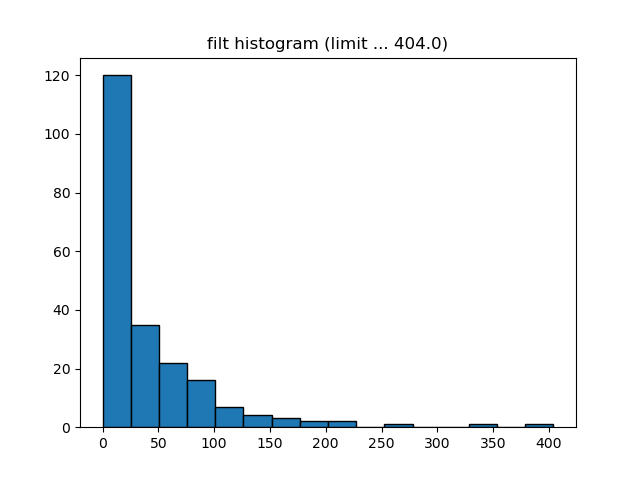

In [14]:
hist_max = data['ehist'][0][1]

# convert image data to energies (using calibration)
_en0 = rutils.tot2energy(data['filt'], det_id)
print("nan energy values: %d" % (np.count_nonzero(np.isnan(_en0)),))
_en0[np.isnan(_en0)] = 0

hist0calc, histedges = rutils.calc_histogram(_en0, en_max=hist_max, nbins=16)

plt.figure()
plt.subplot(111), plt.title('filt histogram (limit ... %.1f)' % (hist_max,))
plt.bar(histedges[:-1], hist0calc, width=np.diff(histedges), edgecolor="black", align="edge");

print('satellite:', data['ehist'][0][0])
print('hist0calc:', hist0calc)